#Introduction
Introduction to be modified

# Installs

In [1]:
%pip install mlxtend


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Imports
These are the libraries this notebook is going to use. if you're having difficulty with executing the notebook make sure to have all modules correctly installed in your enviroment.

In [2]:
import pandas as pd
import requests
from io import BytesIO
import numpy as np
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Getting Started

In [3]:
#data_url = "https://raw.githubusercontent.com/Abd-Elhakim-Arabet/TC-Analysis/main/attempt_20_01.xlsx"
#response = requests.get(data_url, verify=False)
#sheets_to_combine = ["Feuil1"]
#data = pd.read_excel(BytesIO(response.content), sheet_name=sheets_to_combine, engine='openpyxl')
#data = pd.concat(data.values(), ignore_index=True)


file_path = 'dataset.csv'
data = pd.read_csv(file_path)

# Drop the ID column
data = data.drop(['ID'],axis=1)

print(f'Number of instances = {data.shape[0]}' )
print(f'Number of attributes = {data.shape[1]}' )
data.keys()


Number of instances = 973
Number of attributes = 24


Index(['SID', 'Sex', 'Age', 'Wilaya', 'TC Type', 'Nodule Count', 'TNM',
       'Echography', 'Cytopuncture', 'Diameter', 'Location',
       'Infected Area Count', 'ATCD', 'Family Situation', 'Discovery Method',
       'Surgery Type', 'LN Dissection', 'Post-Surgery Status', 'LN Metastasis',
       'Distant Metastasis', 'Iodine Dosage', 'Capsular Invasion',
       'Muscle Tissue Invasion', 'Vascular Embolism'],
      dtype='object')

# Initial Transformation of the Data Types

Translating column names to english from french

In [4]:
#Translate french to english
def remove_accents(text):
    return ''.join(
        char for char in unicodedata.normalize('NFD', text)
        if unicodedata.category(char) != 'Mn'
    )

data.columns = [remove_accents(col) for col in data.columns]


Convert Diametre to a float number in cm

In [5]:
def convert_to_cm(value):
    if value is np.nan:
        return None
    if "cm" in value:
        return float(value.replace(" cm", "")) 
    elif "mm" in value:
        return float(value.replace(" mm", "")) / 10
    else:
        return None 
    
data["Diameter"] = data["Diameter"].apply(convert_to_cm)

In [6]:
data.head()['Diameter']

0    NaN
1    1.5
2    1.0
3    1.4
4    2.0
Name: Diameter, dtype: float64

# Handling Missing Values

In [7]:
count_na = (data.isna()).sum()

print("Empty Cells in each column")
print(count_na)

Empty Cells in each column
SID                         1
Sex                        10
Age                        15
Wilaya                     27
TC Type                    26
Nodule Count              220
TNM                        47
Echography                211
Cytopuncture               62
Diameter                   94
Location                   87
Infected Area Count       391
ATCD                       37
Family Situation           33
Discovery Method           51
Surgery Type               43
LN Dissection             111
Post-Surgery Status       141
LN Metastasis             108
Distant Metastasis        111
Iodine Dosage             500
Capsular Invasion         106
Muscle Tissue Invasion    107
Vascular Embolism         110
dtype: int64


*Numeric Data:*

We will handle the missing numerical data by filling empty cells with the median value of that column 

In [8]:
data["Nodule Count"] = data["Nodule Count"].fillna(data["Nodule Count"].median())
data["Diameter"] = data["Diameter"].fillna(data["Diameter"].median())
data["Age"] = data["Age"].fillna(data["Age"].median())

*Categorical Data:*

To be handeled later, currently left as NaN

In [9]:
#To Do

# Outliers
Outliers are data instances with characteristics that are considerably different from the rest of the dataset. 

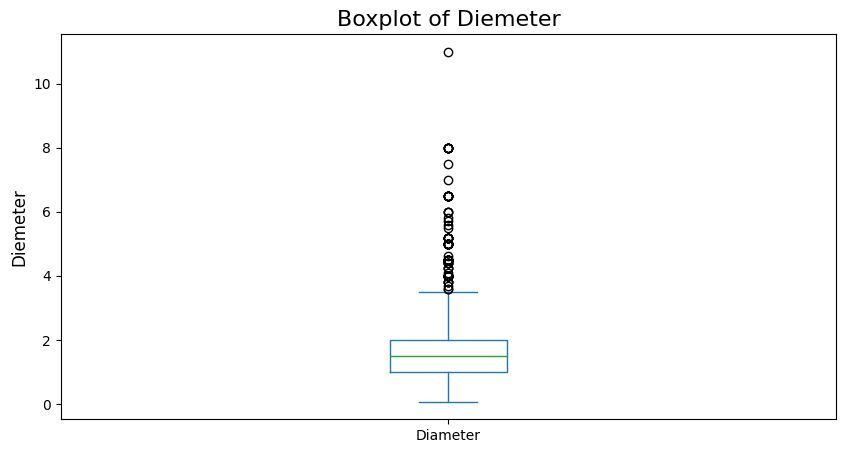

In [10]:
plt.figure(figsize=(10, 5))  
data['Diameter'].plot(kind='box', figsize=(10, 5))

plt.title("Boxplot of Diemeter", fontsize=16)
plt.ylabel("Diemeter", fontsize=12)

plt.show()

The boxplots suggest that only 8 instances have abnormally high Diemeter length. To discard the outliers, we can compute the Z-score and remove those instances containing a diameter with abnormally high or low Z-score (e.g., if Z > 3 or Z <= -3).

In [11]:
Z = (data['Diameter']-data['Diameter'].mean())/data['Diameter'].std()

In [12]:
print( f'Number of rows before discarding outliers = {data.__len__()}' )

data = data[(Z <= 3) & (Z >= -3)]
print( f'Number of rows before discarding outliers = {data.__len__()}' )

Number of rows before discarding outliers = 973
Number of rows before discarding outliers = 951


# Duplicates


In [13]:
dups = data.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 0


With no duplicates in the data, no need to handle them

ALERT: WHEN MERGING THE ENTIRE SHEETS RECHECK FOR DUPLICATES

# Unify Values Names

In [14]:
data['Echography'].value_counts()

Echography
tirads 5    369
tirads 4    230
tirads 3    115
tirads 6     21
tirads 2      4
tirads 1      3
Name: count, dtype: int64

# Visualize Correlation
we'll visualize correlation between the severity of the cancer anfd the diamter of the nodules

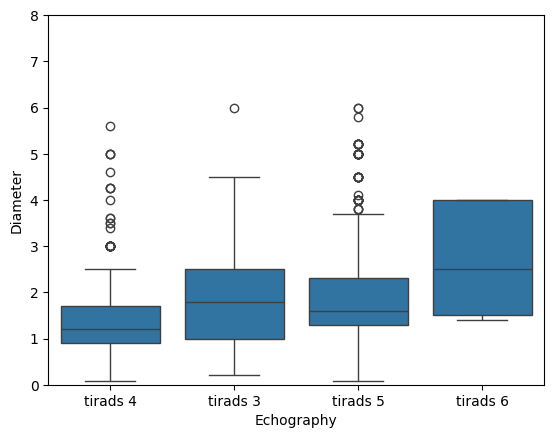

In [15]:
# Visualize relationship between price and room_type
# choose the data where at least 10 valures of Echography type
category_counts = data["Echography"].value_counts()
valid_categories = category_counts[category_counts >= 10].index
filtered_data = data[data["Echography"].isin(valid_categories)]

sns.boxplot(x = 'Echography', y = 'Diameter', data = filtered_data)
plt.ylim(0, 8)
plt.xlabel('Echography')
plt.ylabel('Diameter')
plt.show() 

Although some noise in the data, it seems that the bigger the severity of the cancer the bigger the diameter

# Correlation Analysis

We'll analyse correlation between some attributes

The most notable relationships are between Surgery Type, LN Metastasis, and Distant Metastasis (correlations around 0.43-0.44). These stronger correlations make clinical sense, as the presence of metastases often influences surgical decision-making. It's interesting that patient age, tumor diameter, and imaging findings (Echography_tirads) show very weak correlations with other variables, suggesting they may be independently important factors in clinical assessment rather than being strongly linked to other disease characteristics.

<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
/var/folders/c2/g_xbtkfn0c1g2fbklbv3pmd80000gn/T/ipykernel_40337/2891152731.py:13: SyntaxWarning: invalid escape sequence '\d'
  data_copy['Echography'] = data_copy['Echography'].str.extract('(\d+)').astype(int)


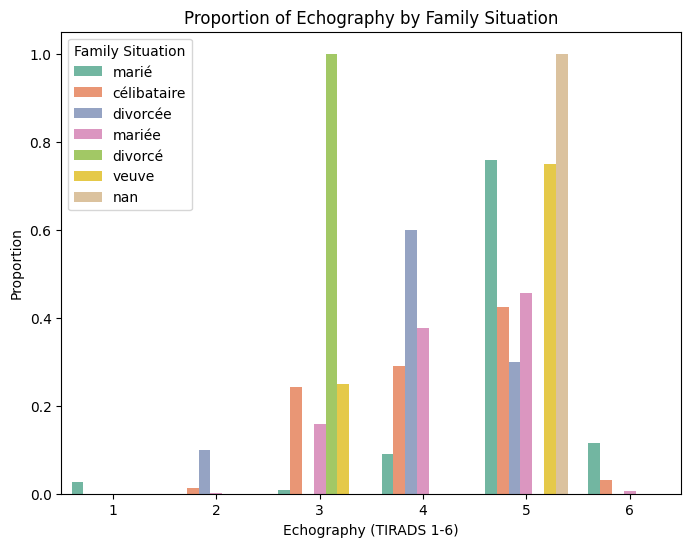


Cross-tabulation between Family Situation and Echography:
Echography        1  2    3    4    5   6  Total
Family Situation                                
célibataire       0  2   40   48   70   5    165
divorcé           0  0    1    0    0   0      1
divorcée          0  1    0    6    3   0     10
marié             3  0    1   10   85  13    112
mariée            0  1   70  166  201   3    441
nan               0  0    0    0    1   0      1
veuve             0  0    3    0    9   0     12
Total             3  4  115  230  369  21    742

Chi-Square Test Results:
Chi2 Statistic: 158.50845360859296
P-value: 2.0383113393963531e-19
Degrees of Freedom: 30
Expected frequencies:
[[6.67115903e-01 8.89487871e-01 2.55727763e+01 5.11455526e+01
  8.20552561e+01 4.66981132e+00]
 [4.04312668e-03 5.39083558e-03 1.54986523e-01 3.09973046e-01
  4.97304582e-01 2.83018868e-02]
 [4.04312668e-02 5.39083558e-02 1.54986523e+00 3.09973046e+00
  4.97304582e+00 2.83018868e-01]
 [4.52830189e-01 6.03773585e

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Copy the original data
data_copy = data.copy()

# Replace NaN values with 'tirads 0' in the 'Echography' column
data_copy['Echography'] = data_copy['Echography'].replace('nan', 'tirads 0')

# Extract numbers from 'Echography' and convert to integer
data_copy['Echography'] = data_copy['Echography'].str.extract('(\d+)').astype(int)

# Remove rows where 'Echography' is 0 (TIRADS 0)
data_copy = data_copy[data_copy['Echography'] != 0]

# Ensure the correct column name for Family Situation
X = data_copy[['Family Situation', 'Echography']]

# Calculate proportions of 'Echography' by 'Family Situation'
proportions = data_copy.groupby(['Family Situation', 'Echography']).size() / data_copy.groupby('Family Situation').size()

# Reset index and name the 'Proportion' column
proportions = proportions.reset_index(name='Proportion')

# Plot the proportions using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='Echography', y='Proportion', hue='Family Situation', data=proportions, palette='Set2')

plt.title("Proportion of Echography by Family Situation")
plt.xlabel("Echography (TIRADS 1-6)")
plt.ylabel("Proportion")
plt.legend(title="Family Situation")
plt.show()

# Cross-tabulation between Family Situation and Echography
cross_tab = pd.crosstab(data_copy['Family Situation'], data_copy['Echography'], margins=True, margins_name="Total")

# Print the cross-tabulation
print("\nCross-tabulation between Family Situation and Echography:")
print(cross_tab)

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(cross_tab.iloc[:-1, :-1])

# Print the Chi-Square test results
print("\nChi-Square Test Results:")
print(f"Chi2 Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected frequencies:")
print(expected)

# Interpretation based on p-value
if p < 0.05:
    print("\nThere is a statistically significant relationship between Family Situation and Echography (p < 0.05).")
else:
    print("\nThere is no statistically significant relationship between Family Situation and Echography (p >= 0.05).")

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
/var/folders/c2/g_xbtkfn0c1g2fbklbv3pmd80000gn/T/ipykernel_40337/1543959642.py:4: SyntaxWarning: invalid escape sequence '\d'
  data_copy['Echography'] = data_copy['Echography'].str.extract('(\d+)').astype(int)


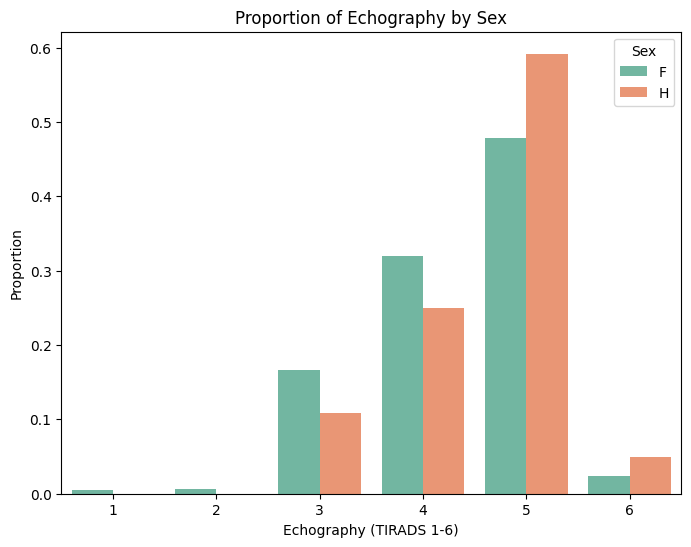


Cross-tabulation between Sex and Echography:
Echography  1  2    3    4    5   6  Total
Sex                                       
F           3  4  102  197  294  15    615
H           0  0   13   30   71   6    120
Total       3  4  115  227  365  21    735

Chi-Square Test Results:
Chi2 Statistic: 10.011956328157131
P-value: 0.07489717688062539
Degrees of Freedom: 5
Expected frequencies:
[[  2.51020408   3.34693878  96.2244898  189.93877551 305.40816327
   17.57142857]
 [  0.48979592   0.65306122  18.7755102   37.06122449  59.59183673
    3.42857143]]

There is a statistically significant relationship between Famiuly Situation and Echography (p < 0.1).


In [ ]:
data_copy = data.copy()

data_copy['Echography'] = data_copy['Echography'].replace('nan', 'tirads 0')
data_copy['Echography'] = data_copy['Echography'].str.extract('(\d+)').astype(int)

data_copy = data_copy[data_copy['Echography'] != 0]

X = data_copy[['Sex', 'Echography']]  

data_copy = data_copy[~data_copy['Sex'].isin(['FF', 'nan'])]

proportions = data_copy.groupby(['Sex', 'Echography']).size() / data_copy.groupby('Sex').size()

proportions = proportions.reset_index(name='Proportion')

plt.figure(figsize=(8, 6))
sns.barplot(x='Echography', y='Proportion', hue='Sex', data=proportions, palette='Set2')

plt.title("Proportion of Echography by Sex")
plt.xlabel("Echography (TIRADS 1-6)")
plt.ylabel("Proportion")
plt.legend(title="Sex")
plt.show()

cross_tab = pd.crosstab(data_copy['Sex'], data_copy['Echography'], margins=True, margins_name="Total")
print("\nCross-tabulation between Sex and Echography:")
print(cross_tab)

chi2, p, dof, expected = chi2_contingency(cross_tab.iloc[:-1, :-1])  
print("\nChi-Square Test Results:")
print(f"Chi2 Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected frequencies:")
print(expected)

if p < 0.1:
    print("\nThere is a statistically significant relationship between Sex and Echography (p < 0.1).")
else:
    print("\nThere is no statistically significant relationship between Sex and Echography (p >= 0.1).")

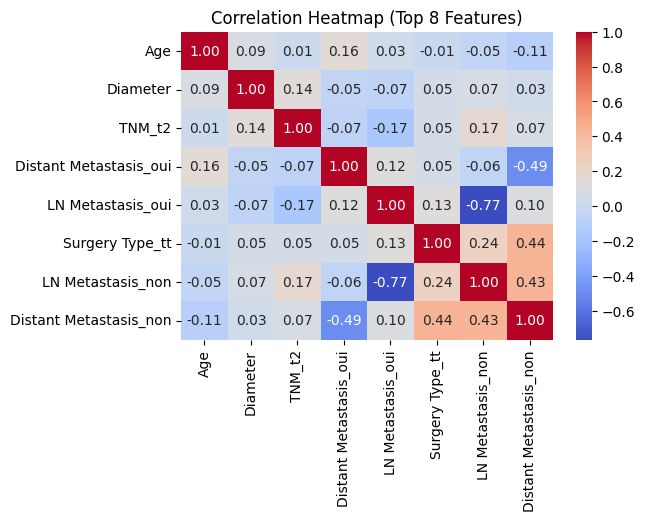

In [16]:
# Convert categorical columns using One-Hot Encoding
categorical_columns = [
    "Sex", "Wilaya", "TC Type", "Echography", "Cytopuncture", "Location", "Infected Area Count", "ATCD", 
    "Family Situation", "Discovery Method", "Surgery Type", "LN Dissection", "Post-Surgery Status", 
    "LN Metastasis", "Distant Metastasis", "Iodine Dosage", "Capsular Invasion", "Muscle Tissue Invasion", 
    "Vascular Embolism", "TNM"  
]

for col in categorical_columns:
    data[col] = data[col].astype(str)


data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
selected_features = ["Age", "Diameter", "TNM_t2", "Distant Metastasis_oui", 
    "LN Metastasis_oui", "Surgery Type_tt", "LN Metastasis_non", "Distant Metastasis_non" ]

correlation_matrix = data_encoded[selected_features].corr()

plt.figure(figsize=(6, 4)) 
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Top 8 Features)")
plt.show()

# Association Rules
first we try uncover the relation between the surgery type and the cancer not spreading

In [18]:
categorical_data = data[["Echography", "Cytopuncture", "Surgery Type", "TNM", "Capsular Invasion", "LN Metastasis"]]

categorical_data = pd.get_dummies(categorical_data)

frequent_itemsets = apriori(categorical_data, min_support=0.5, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

print(rules[["antecedents", "consequents", "support", "confidence", "lift"]])

                                   antecedents  \
0                            (Surgery Type_tt)   
1                      (Capsular Invasion_non)   
2                            (Surgery Type_tt)   
3                          (LN Metastasis_non)   
4                      (Capsular Invasion_non)   
5                          (LN Metastasis_non)   
6         (Surgery Type_tt, LN Metastasis_non)   
7     (Surgery Type_tt, Capsular Invasion_non)   
8   (Capsular Invasion_non, LN Metastasis_non)   
9                          (LN Metastasis_non)   
10                     (Capsular Invasion_non)   

                                 consequents   support  confidence      lift  
0                    (Capsular Invasion_non)  0.747634    0.791759  1.044332  
1                          (Surgery Type_tt)  0.747634    0.986130  1.044332  
2                        (LN Metastasis_non)  0.633018    0.670379  1.043421  
3                          (Surgery Type_tt)  0.633018    0.985270  1.043421  
4   

Although The results seem to confirm at first that the data when the disease is not spread the operation is performed. But we have to consider the following 

In [19]:
print(f"Total Surgeries Proportion: { data["Surgery Type"].value_counts()["tt"]/data["Surgery Type"].value_counts().sum()}")
print(f"Absence of Capsular Invasion: { data["Capsular Invasion"].value_counts()["non"]/data["Capsular Invasion"].value_counts().sum()}")
print(f"Absence of LN Metastasis: { data["LN Metastasis"].value_counts()["non"]/data["LN Metastasis"].value_counts().sum()}")

Total Surgeries Proportion: 0.9442691903259727
Absence of Capsular Invasion: 0.7581493165089379
Absence of LN Metastasis: 0.6424815983175605


These Values indicate that the association rules are high because the proportion of these values in the dataset is high. So we disregard the obtained rules.

# Clustering


We Test If there is correlation between the age and the risk of the cancer 

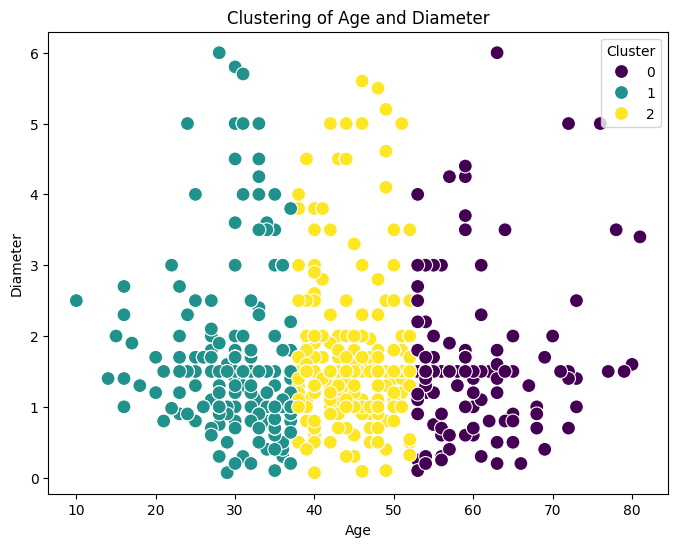

In [20]:
data_copy = data.copy()

X = data_copy[['Age', 'Diameter']]

kmeans = KMeans(n_clusters=3, random_state=42)
data_copy['Cluster'] = kmeans.fit_predict(X)


plt.figure(figsize=(8, 6))
sns.scatterplot(data=data_copy, x='Age', y='Diameter', hue='Cluster', palette='viridis', s=100, marker='o')
plt.title("Clustering of Age and Diameter")
plt.xlabel("Age")
plt.ylabel("Diameter")
plt.legend(title="Cluster")
plt.show()


This suggests that no relation exists between the age and diameter of the tcp (Which is a bit odd)

# Classification
We try to predict the post surgery status using different features

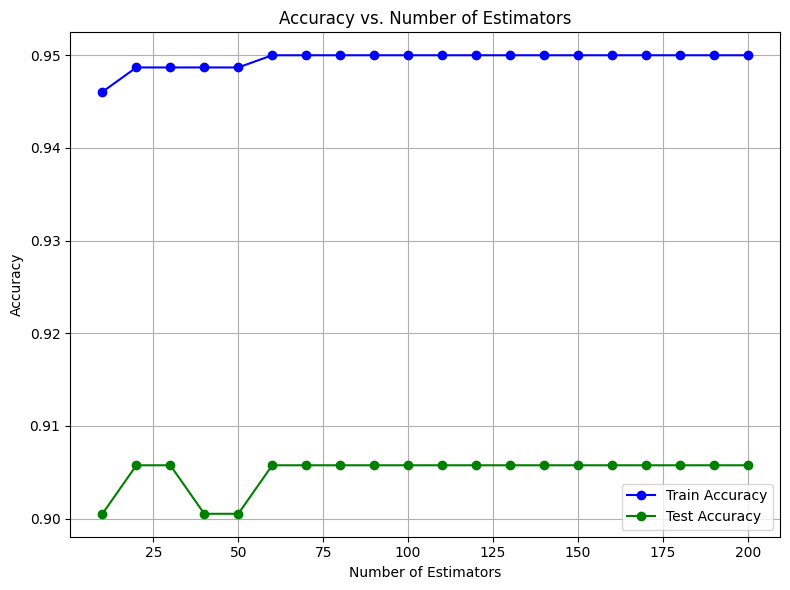

F1 Score: 0.9042


In [ ]:


features = ["Diameter", "Infected Area Count", "Echography", "TNM"]

data_filtered = data.dropna(subset=features + ["Post-Surgery Status"])

y = data_filtered["Post-Surgery Status"]

X = data_filtered[features]
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

train_accuracies = []
test_accuracies = []

n_estimators_range = range(10, 201, 10) 

for n in n_estimators_range:
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_accuracies.append(accuracy_score(y_train, y_train_pred))
    test_accuracies.append(accuracy_score(y_test, y_test_pred))
    


train_f1 = f1_score(y_train, y_train_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
plt.figure(figsize=(8, 6))

plt.plot(n_estimators_range, train_accuracies, marker='o', label='Train Accuracy', color='blue')
plt.plot(n_estimators_range, test_accuracies, marker='o', label='Test Accuracy', color='green')
plt.title("Accuracy vs. Number of Estimators")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
print(f"F1 Score: {test_f1:.4f}")


Both the accuracy and the f1 score a high, indicating a good model prediction

we try and generate a prediction from the model

In [28]:
new_data = [[40, 2.5, 'bifocal', 'tirads 6', 't2']]  

new_data_df = pd.DataFrame(new_data, columns=["Age", "Diameter", "Infected Area Count", "Echography", "TNM"])

new_data_encoded = pd.get_dummies(new_data_df, drop_first=True)

new_data_encoded = new_data_encoded.reindex(columns=X.columns, fill_value=0)

new_prediction = model.predict(new_data_encoded)

print(f"Prediction for new data: {new_prediction[0]}")

Prediction for new data: simples
